In [1]:
# imports
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from esem import gp_model
from eofs.xarray import Eof
from utils import *
import gpflow

2024-11-22 05:27:31.246030: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732278451.258811  250630 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732278451.262722  250630 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 05:27:31.277619: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# list of experiment data used for training

train_files= ['ssp126', 'ssp370', 'ssp585', 'historical', 'hist-GHG', 'hist-aer']

### prepare data

In [ ]:
# get data
Xtrain, eof_solvers = create_predictor_data(train_files)
Ytrain_pr = create_predictdand_data(train_files)['pr'].values.reshape(-1, 96*144)

Xtest = get_test_data('ssp245', eof_solvers)
Ytest = xr.open_dataset('../test/outputs_ssp245.nc').compute()
pr_truth = 86400 * Ytest['pr'].mean('member') # convert pr to mm/day, default unit is kg/m²/s

In [4]:
# drop rows including nans
train_nan_mask = Xtrain.isna().any(axis=1).values
Xtrain = Xtrain.dropna(axis=0, how='any')
Ytrain_pr = Ytrain_pr[~train_nan_mask]
assert Xtrain.shape[0]==Ytrain_pr.shape[0]

test_nan_mask = Xtest.isna().any(axis=1).values
Xtest = Xtest.dropna(axis=0, how='any')
pr_truth = pr_truth[~test_nan_mask]

In [5]:
# Standardize predictor fields requiring standardization (non-EOFs)
train_CO2_mean, train_CO2_std = Xtrain['CO2'].mean(), Xtrain['CO2'].std()
train_CH4_mean, train_CH4_std = Xtrain['CH4'].mean(), Xtrain['CH4'].std()

Xtrain['CO2'] = (Xtrain['CO2'] - train_CO2_mean) / train_CO2_std
Xtrain['CH4'] = (Xtrain['CH4'] - train_CH4_mean) / train_CH4_std

Xtest['CO2'] = (Xtest['CO2'] - train_CO2_mean) / train_CO2_std
Xtest['CH4'] = (Xtest['CH4'] - train_CH4_mean) / train_CH4_std

In [6]:
# Standardize predictand fields
train_pr_mean, train_pr_std = Ytrain_pr.mean(), Ytrain_pr.std()
Ytrain_pr = (Ytrain_pr - train_pr_mean) / train_pr_std

### Model

In [7]:
kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0]) # active_dims specifies which dimension the kernel is applied to
kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])

kernel_BC = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2

I0000 00:00:1732278460.080766  250630 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79379 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:01:00.0, compute capability: 8.0


In [8]:
np.random.seed(5)

"""
In Gaussian Processes, a mean function represents the "prior mean" or the expected value
of the function at any input point before observing any data.
"""
mean = gpflow.mean_functions.Constant()

model = gpflow.models.GPR(data=(Xtrain.astype(np.float64), # cast to float64 because gpflow requires numerical stability
                                Ytrain_pr.astype(np.float64)),
                          kernel = kernel,
                          mean_function = mean)

In [9]:
# define optimizer
optimizer = gpflow.optimizers.Scipy()

# train
optimizer.minimize(model.training_loss,
                   variables=model.trainable_variables,
                   options=dict(disp=True, maxiter=1000))

I0000 00:00:1732278464.500881  250688 cuda_solvers.cc:178] Creating GpuSolver handles for stream 0x558c7ebca720
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46144D+07    |proj g|=  6.59595D+05

At iterate    1    f=  1.44612D+07    |proj g|=  1.03765D+05

At iterate    2    f=  1.44451D+07    |proj g|=  1.01717D+05

At iterate    3    f=  1.43598D+07    |proj g|=  3.61807D+05

At iterate    4    f=  1.42008D+07    |proj g|=  6.35110D+05

At iterate    5    f=  1.40093D+07    |proj g|=  4.53002D+05

At iterate    6    f=  1.39421D+07    |proj g|=  1.07261D+05

At iterate    7    f=  1.39380D+07    |proj g|=  1.25869D+04

At iterate    8    f=  1.39374D+07    |proj g|=  1.47148D+04

At iterate    9    f=  1.39363D+07    |proj g|=  5.03315D+04

At iterate   10    f=  1.39340D+07    |proj g|=  9.61485D+04

At iterate   11    f=  1.39291D+07    |proj g|=  1.52290D+05

At iterate   12    f=  1.39207D+07    |proj g|=  1.90517D+05

At iterate   13    f=  1.3

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 13878416.465636913
        x: [ 4.890e+00  2.082e-02 ...  2.367e-01  2.222e-02]
      nit: 299
      jac: [ 8.350e+00 -5.607e+01 ... -6.784e+01 -2.699e+01]
     nfev: 343
     njev: 343
 hess_inv: <18x18 LbfgsInvHessProduct with dtype=float64>

### make prediction

In [10]:
# predict
standard_posterior_mean, standard_posterior_var = model.predict_y(Xtest.values) # predicted mean of GP, predicted variance of GP
posterior_mean = standard_posterior_mean * train_pr_std + train_pr_mean # transform mean prediction to original scale
posterior_stddev = np.sqrt(standard_posterior_var) * train_pr_std # transform variance prediction to original scale standard deviation

In [11]:
# put output back into xarray format for calculating RMSE/plotting
posterior_pr = np.reshape(posterior_mean, [86, 96, 144])
posterior_pr_stddev = np.reshape(posterior_stddev, [86, 96, 144])

posterior_pr_data = xr.DataArray(posterior_pr, dims=pr_truth.dims, coords=pr_truth.coords)
posterior_pr_std_data = xr.DataArray(posterior_pr_stddev, dims=pr_truth.dims, coords=pr_truth.coords)

In [12]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(pr_truth[35], posterior_pr_data[35])}")
print(f"RMSE at 2100: {get_rmse(pr_truth[85], posterior_pr_data[85])}")
print(f"RMSE 2045-2055: {get_rmse(pr_truth[30:41], posterior_pr_data[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(pr_truth[75:], posterior_pr_data[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(pr_truth[35:], posterior_pr_data[35:]).mean()}")

# RMSE for average field over last 20 years
print(f"RMSE average last 20y: {get_rmse(pr_truth[-20:].mean(dim='time'), posterior_pr_data[-20:].mean(dim='time'))}")

RMSE at 2050: 0.38358933179796506
RMSE at 2100: 0.5677319656198956
RMSE 2045-2055: 0.49878060177806066
RMSE 2090-2100: 0.5261891933905046
RMSE 2050-2100: 0.5337930762172088
RMSE average last 20y: 0.17560346542905994


[Text(0.5, 1.0, 'Difference')]

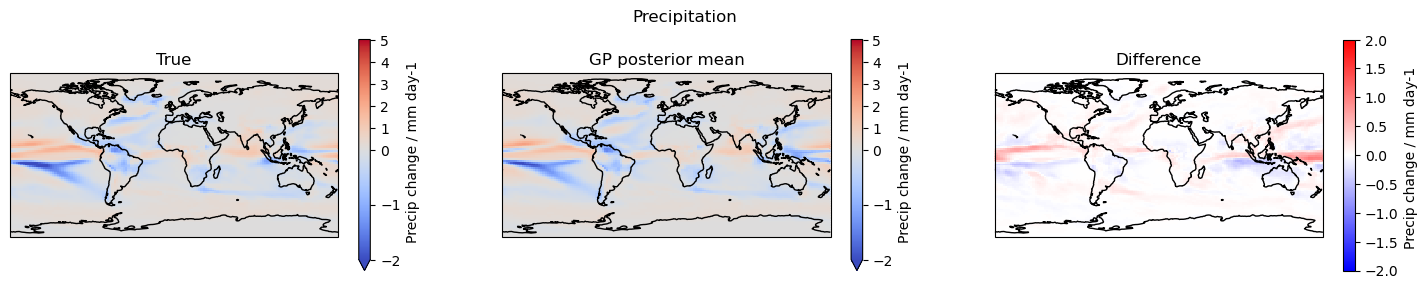

In [13]:
from matplotlib import colors
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Precipitation')

# Test
plt.subplot(131, projection=proj)
pr_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Precip change / mm day-1 "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
posterior_pr_data.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                       cbar_kwargs={"label":"Precip change / mm day-1 "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = pr_truth - posterior_pr_data
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"Precip change / mm day-1 "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

In [14]:
model

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,Identity,,True,"(1,)",float64,[0.02222345]
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.7036111603622266
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,4.89768
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,5.782079471538937e-23
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,45.4764
GPR.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,0.019000624069268043
GPR.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[1.91525, 74.69821, 52.75336..."
GPR.kernel.kernels[3].variance,Parameter,Softplus,,True,(),float64,0.27657674195095316
GPR.kernel.kernels[3].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[6.52178, 7.57278, 12.40975..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.8184576881089053
